## Matching Scales

In [335]:
import numpy as np
import matplotlib.pyplot as plt
import ipywidgets
import pandas as pd
import math
import cmath

import pywt # PyWavelets

In [336]:
# NCL Output
sst_data = np.loadtxt("data/nino3sst_trimmed.txt")
time_0 = 1871.0
dt = 0.25  # years (4 per year, seasonal)

ncl_data = np.genfromtxt("data/ncl_csv.csv", skip_header=1, delimiter=',')
ncl_data = ncl_data[:,1]
time_range = (np.arange(0, len(ncl_data)) * dt) + time_0 # from 1871.00 to 1996.75
ncl_df = pd.DataFrame({'time (years)': time_range, 'temperature (C)': ncl_data})
ncl_df.head()

,time (years),temperature (C)
0,1871.00,-0.15
1,1871.25,-0.30
2,1871.50,-0.14
3,1871.75,-0.41
4,1872.00,-0.46


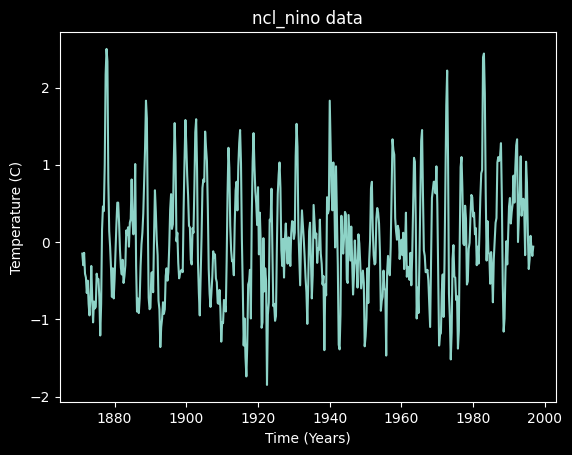

In [337]:
plt.style.use('dark_background')
fig, ax = plt.subplots()
fig = plt.plot(ncl_df["time (years)"], ncl_df["temperature (C)"])
plt.title("ncl_nino data")
plt.xlabel("Time (Years)")
plt.ylabel("Temperature (C)")
plt.show()

In [338]:
# PyWavelets complex morlet
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#wavelet-bandwidth-and-center-frequencies

wavelets (4): 
['cmor1.0-0.5', 'cmor1.0-0.8', 'cmor1.0-1.0', 'cmor1.0-1.2']


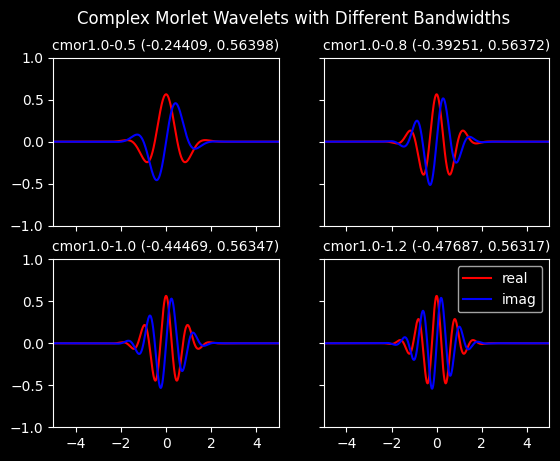

In [339]:
# plot complex morlet wavelets with different center frequencies and bandwidths
y_range = np.arange(0.5, 1.5, 0.25)
wavelets = [f"cmor1.0-{y:.1f}" for y in y_range]
print(f"wavelets ({len(wavelets)}): \n{wavelets}")
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real", c="red")
    ax.plot(x, np.imag(psi), label="imag", c="blue")
    ax.set_title(f"{wavelet} ({np.min(np.real(psi)):.5f}, {np.max(np.real(psi)):.5f})", fontsize=10)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-1, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with Different Bandwidths")
plt.show()

wavelets (4): 
['cmor1.0-1.0', 'cmor1.5-1.0', 'cmor2.0-1.0', 'cmor2.5-1.0']


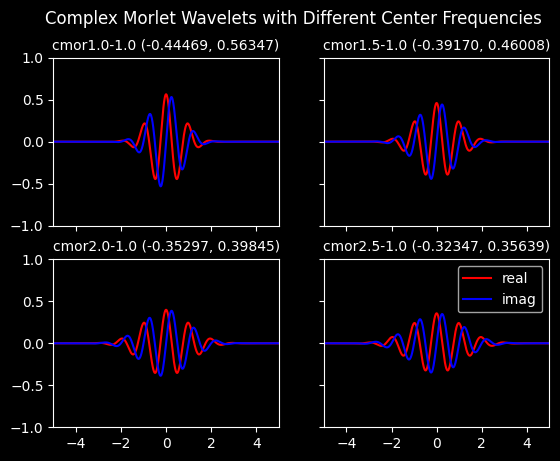

In [340]:
# plot complex morlet wavelets with different center frequencies
x_range = np.arange(1.0, 3, 0.5)#[0.5, 1.5, 2.5]
wavelets = [f"cmor{x:.1f}-1.0" for x in x_range]
print(f"wavelets ({len(wavelets)}): \n{wavelets}")
fig, axs = plt.subplots(2, 2, sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real", c="red")
    ax.plot(x, np.imag(psi), label="imag", c="blue")
    ax.set_title(f"{wavelet} ({np.min(np.real(psi)):.5f}, {np.max(np.real(psi)):.5f})", fontsize=10)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-1, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with Different Center Frequencies")
plt.show()

wavelets (16) (4, 4): 
['cmor1.0-0.5', 'cmor1.0-0.8', 'cmor1.0-1.0', 'cmor1.0-1.2', 'cmor1.5-0.5', 'cmor1.5-0.8', 'cmor1.5-1.0', 'cmor1.5-1.2', 'cmor2.0-0.5', 'cmor2.0-0.8', 'cmor2.0-1.0', 'cmor2.0-1.2', 'cmor2.5-0.5', 'cmor2.5-0.8', 'cmor2.5-1.0', 'cmor2.5-1.2']


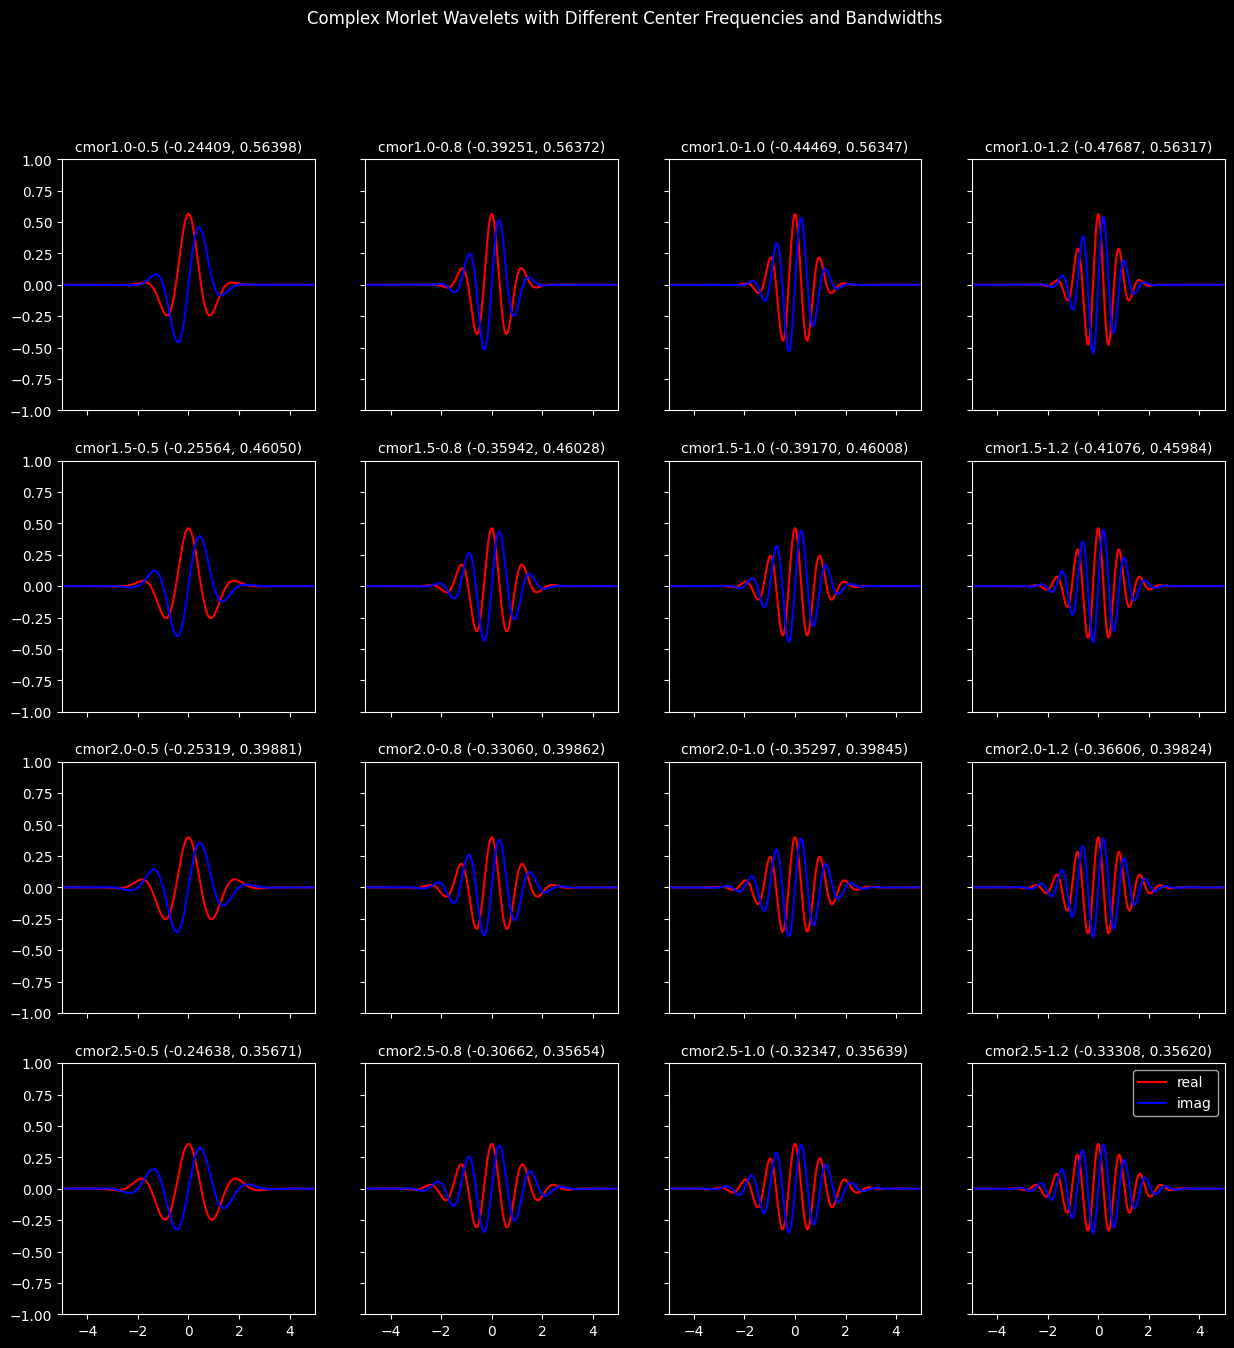

In [341]:
# plot complex morlet wavelets with different center frequencies and bandwidths
x_range = np.arange(1.0, 3.0, 0.5)#[0.5, 1.5, 2.5]
y_range = np.arange(0.5, 1.5, 0.25)#[0.5, 1.0, 1.5]
wavelets = [f"cmor{x:.1f}-{y:.1f}" for x in x_range for y in y_range]
sub_plot_x = int(math.sqrt(len(wavelets)))
sub_plot_y = len(wavelets) - sub_plot_x**2
if sub_plot_y == 0: sub_plot_y = sub_plot_x
print(f"wavelets ({len(wavelets)}) ({sub_plot_x}, {sub_plot_y}): \n{wavelets}")
fig, axs = plt.subplots(sub_plot_x, sub_plot_y, figsize=(15, 15), sharex=True, sharey=True)
for ax, wavelet in zip(axs.flatten(), wavelets):
    [psi, x] = pywt.ContinuousWavelet(wavelet).wavefun(10)
    ax.plot(x, np.real(psi), label="real", c="red")
    ax.plot(x, np.imag(psi), label="imag", c="blue")
    ax.set_title(f"{wavelet} ({np.min(np.real(psi)):.5f}, {np.max(np.real(psi)):.5f})", fontsize=10)
    ax.set_xlim([-5, 5])
    ax.set_ylim([-1, 1])
ax.legend()
plt.suptitle("Complex Morlet Wavelets with Different Center Frequencies and Bandwidths")
plt.show()

In [342]:
def complex_morlet_pywavelets(time_step, B, C):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
    part1 = 1/np.sqrt(math.pi*B)
    part2 = math.exp(-np.power(time_step, 2)/B)
    part3 = cmath.exp(1j * 2 * math.pi * C * time_step)
    return part1 * part2 * part3

def morlet_pywavelets(time_step):
    # https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#morlet-wavelet
    # 'morl'
    part1 = math.exp(-np.power(time_step, 2)/2)
    part2 = math.cos(5*time_step)
    return part1*part2

def tc_morlet(time_step):
    # Table 1: https://psl.noaa.gov/people/gilbert.p.compo/Torrence_compo1998.pdf
    i = np.sqrt(-1+0j) # complex i
    omega = 6 # w, nondimensional frequency, defaults to 6 (~2pi)
    eta = time_step # n, wavelet function nondimensional "time" parameter
    part1 = np.power(math.pi, -1/4)
    part2 = cmath.exp(i*omega*eta)
    part3 = math.exp(-np.power(eta, 2)/2)
    return part1 * part2 * part3

In [343]:
# cmorB-C
# https://pywavelets.readthedocs.io/en/latest/ref/cwt.html#complex-morlet-wavelets
# B = bandwidth
# C = center frequency
bandwidth = 2 
center_freq = 6/(2*math.pi) # C * 2 * pi = 2 * pi = approx 6 (morlet default)
amp_multiply = math.sqrt(2)*np.power(math.pi, 1/4)

complex_morlet = f"cmor{bandwidth}-{center_freq}"
[psi, x] = pywt.ContinuousWavelet(complex_morlet).wavefun(10)
[psi_default, x_default] = pywt.ContinuousWavelet(f"cmor{math.sqrt(math.pi)}-{center_freq}").wavefun(10)
[psi_m, x_m] = pywt.ContinuousWavelet('morl').wavefun(10)

tc_output = []
mor_pywt_output = []
cmor_pywt_output = []
for x_value in x:
    tc_output.append(tc_morlet(x_value))
    mor_pywt_output.append(morlet_pywavelets(x_value))
    cmor_pywt_output.append(complex_morlet_pywavelets(x_value, bandwidth, center_freq))

In [344]:
# Verify Equations 

# Integrate to ~0
from scipy.integrate import quad

integrate_range = 100000
cmor_integration = quad(complex_morlet_pywavelets, -integrate_range, integrate_range, args=(bandwidth,center_freq))
tc_integration = quad(tc_morlet, -integrate_range, integrate_range)
print("Verify Integration of Equation == 0")
print(f"cmor_integration {cmor_integration} == (0.0, 0.0) = {cmor_integration == (0.0, 0.0)}")
print(f"tc_integration   {tc_integration} == (0.0, 0.0) = {tc_integration == (0.0, 0.0)}")

Verify Integration of Equation == 0
cmor_integration (0.0, 0.0) == (0.0, 0.0) = True
tc_integration   (0.0, 0.0) == (0.0, 0.0) = True


/home/user/miniconda3/envs/wavelet_tutorial/lib/python3.11/site-packages/scipy/integrate/_quadpack_py.py:611: ComplexWarning: Casting complex values to real discards the imaginary part
  return _quadpack._qagse(func,a,b,args,full_output,epsabs,epsrel,limit)


In [345]:
print(f"range tc morlet output (equation)          = ({np.min(np.real(tc_output))}, {np.max(np.real(tc_output))})")
print(f"range cmor morlet pywavelets output        = ({np.min(np.real(cmor_pywt_output))}, {np.max(np.real(cmor_pywt_output))})")
print(f"range complex morlet pywavelets (equation) = ({np.min(np.real(psi)*amp_multiply)}, {np.max(np.real(psi)*amp_multiply)})")
print(f"min difference = {np.min(np.real(tc_output)) / np.min(np.real(psi)*amp_multiply)}")
print(f"difference = {np.max(np.real(tc_output)) / np.max(np.real(psi)*amp_multiply)}")

range tc morlet output (equation)          = (-0.6573192867703035, 0.7502759291315703)
range cmor morlet pywavelets output        = (-0.34911934116524707, 0.3984910276367554)
range complex morlet pywavelets (equation) = (-0.6573192850858788, 0.7502759291466674)
min difference = 1.000000002562567
difference = 0.9999999999798779


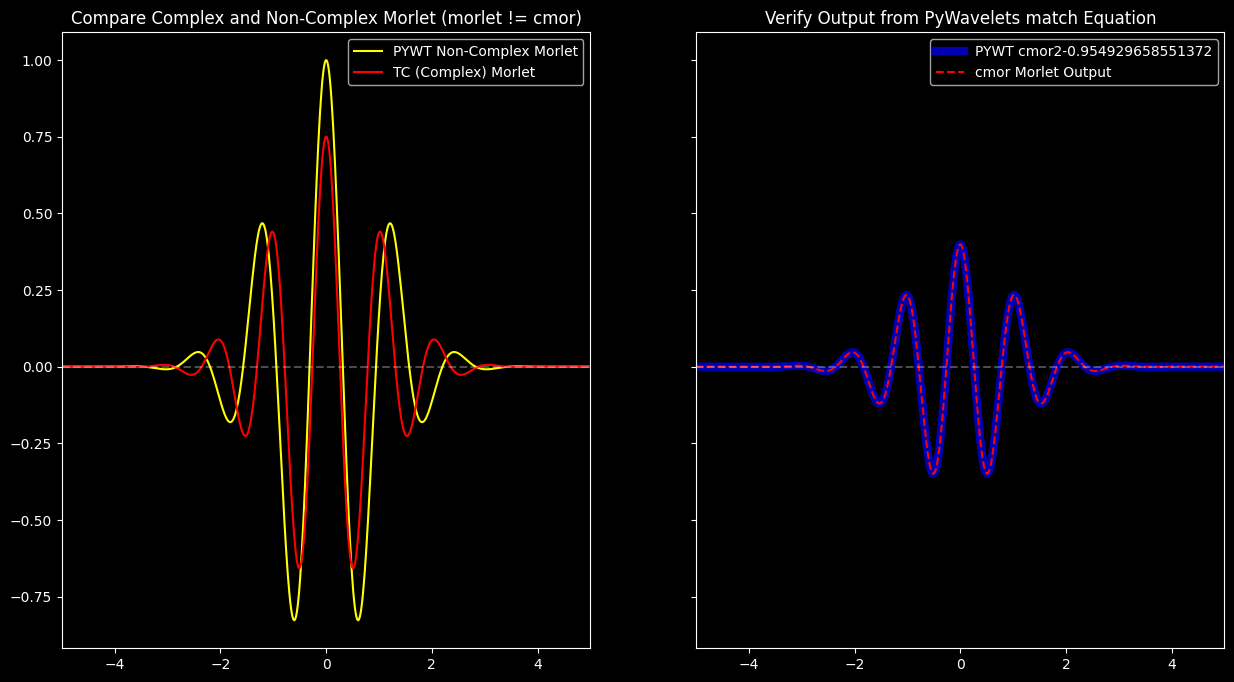

In [346]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 8), sharex=True, sharey=True)
ax1.plot(x, np.real(psi_m), label="PYWT Non-Complex Morlet", c="yellow")
ax1.plot(x, np.real(tc_output), label="TC (Complex) Morlet", c="red")
ax1.set_title("Compare Complex and Non-Complex Morlet (morlet != cmor)")
ax1.axhline(0, linestyle='--', alpha=0.3)
ax1.set_xlim([-5, 5])
ax1.legend()
ax2.plot(x, np.real(psi), label=f"PYWT {complex_morlet}", c="blue", linewidth=6, alpha=0.7)
ax2.plot(x, np.real(cmor_pywt_output), label="cmor Morlet Output", linestyle='--', c="red")
ax2.set_title("Verify Output from PyWavelets match Equation")
ax2.axhline(0, linestyle='--', alpha=0.3)
ax2.legend()
plt.show()

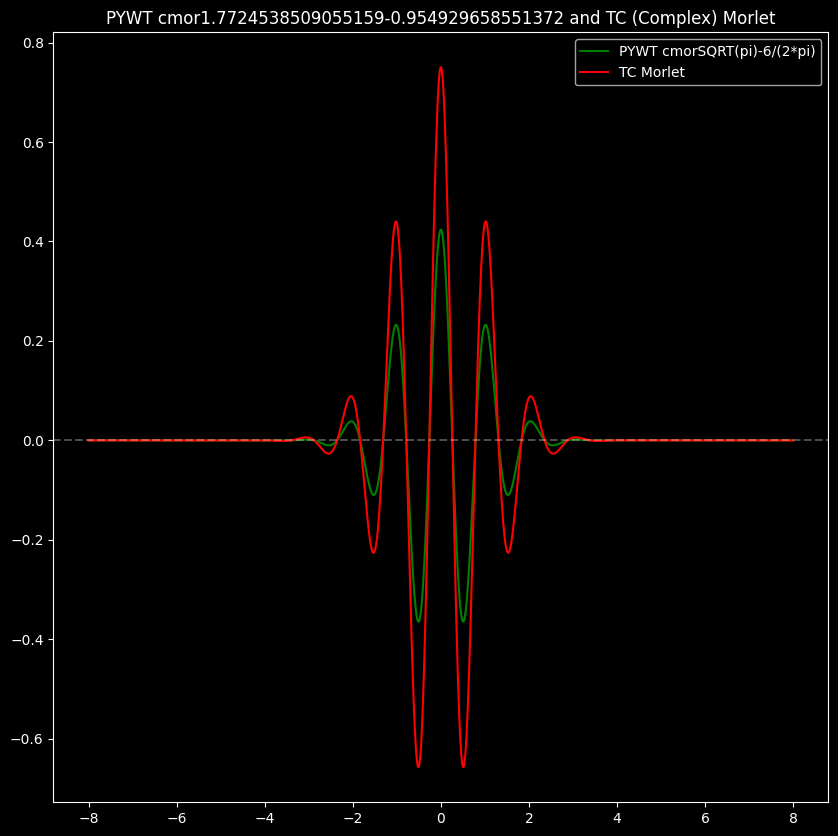

In [353]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, np.real(psi_default), label="PYWT cmorSQRT(pi)-6/(2*pi)", c="green")
ax.plot(x, np.real(tc_output), label="TC Morlet", c="red")
plt.title(f"PYWT cmor{math.sqrt(math.pi)}-{6/(2*math.pi)} and TC (Complex) Morlet")
ax.axhline(0, linestyle='--', alpha=0.3)
ax.legend()
plt.show()

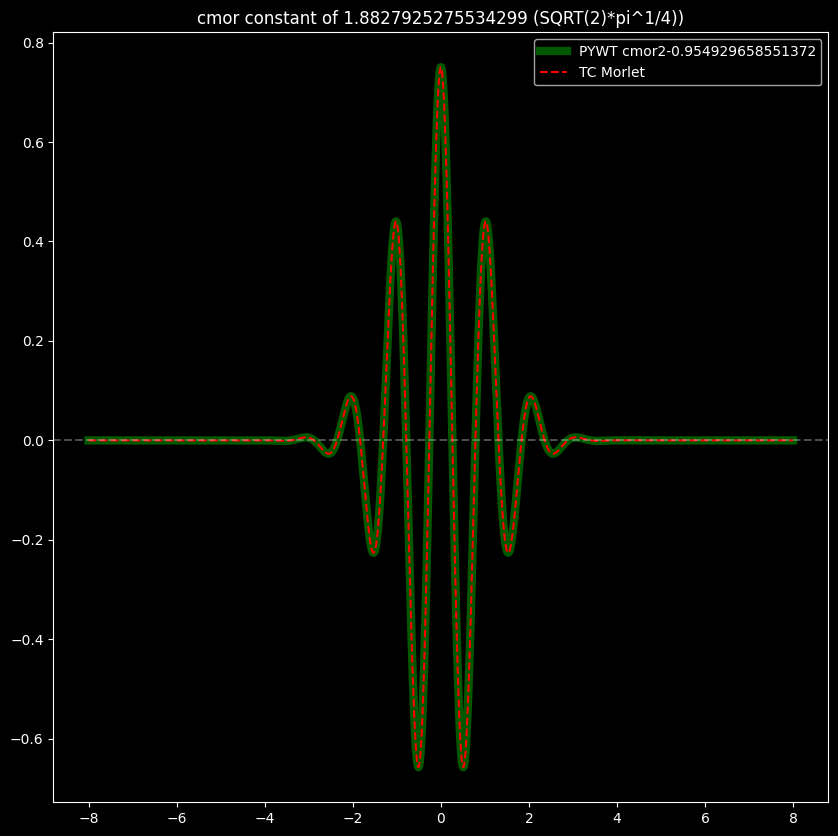

In [358]:
fig, ax = plt.subplots(figsize=(10, 10))
ax.plot(x, np.real(psi)*amp_multiply, label=f"PYWT {complex_morlet}", c="green", linewidth=6, alpha=0.7)
ax.plot(x, np.real(tc_output), label="TC Morlet", c="red", linestyle='--')
plt.title(f"cmor constant of {amp_multiply} (SQRT(2)*pi^1/4))")
ax.axhline(0, linestyle='--', alpha=0.3)
ax.legend()
plt.show()

In [ ]:
# Pywavlets Output
dt = 0.25 # sampling period (time between each y-value)
s0 = 0.25 # smallest scale
dj = 0.25 # spacing between discrete scales
jtot = 44
scales = np.arange(1, jtot+1)
wavelet_coeffs, freqs = pywt.cwt(data=sst_data,
                                 scales=scales,
                                 wavelet=complex_morlet,
                                 sampling_period=dt)

In [ ]:
import cmaps
power_default = np.power((abs(wavelet_coeffs)), 2)
power_default_multiple = np.power((abs(wavelet_coeffs)), 2)*amp_multiply

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6), sharex=False, sharey=False)
ax1.set_yscale("symlog")
ax1.invert_yaxis()
ax1.set_yticks([10, 20, 30, 40, 50])
ax1.set_yticklabels([10, 20, 30, 40, 50])
ax1.contourf(power_default, vmax=(power_default).max(), vmin=(power_default).min(), cmap=cmaps.ncl_default, levels=10)
ax1.contour(power_default, levels=10, colors="k", linewidths=0.5, alpha=0.75)
ax1.set_title("Power Spectrum (Default)")
im = ax1.imshow(power_default, vmax=(power_default).max(), vmin=(power_default).min(), cmap=cmaps.ncl_default, aspect="auto")
ax1.set_xlabel("Time")
ax1.set_ylabel("Scale")
fig.colorbar(im)

ax2.set_yscale("symlog")
ax2.invert_yaxis()
ax2.set_yticks([10, 20, 30, 40, 50])
ax2.set_yticklabels([10, 20, 30, 40, 50])
ax2.contourf(power_default_multiple, vmax=(power_default_multiple).max(), vmin=(power_default_multiple).min(), cmap=cmaps.ncl_default, levels=10)
ax2.contour(power_default_multiple, levels=10, colors="k", linewidths=0.5, alpha=0.75)
ax2.set_title("Power Spectrum (Multiple)")
im2 = ax2.imshow(power_default_multiple, vmax=(power_default_multiple).max(), vmin=(power_default_multiple).min(), cmap=cmaps.ncl_default, aspect="auto")
fig.colorbar(im2)
ax2.set_xlabel("Time")
ax2.set_ylabel("Scale")
plt.show()

In [ ]:
# Compare Matplotlib Image Outputs
def generatePlots(power_data, fig_title):
    fig, ax = plt.subplots()
    plt.style.use('dark_background')
    ax.set_yscale("symlog")
    ax.invert_yaxis()
    ax.set_yticks([10, 20, 30, 40, 50])
    ax.set_yticklabels([10, 20, 30, 40, 50])
    plt.contourf(power_data, vmax=(power_data).max(), vmin=(power_data).min(), cmap=cmaps.ncl_default, levels=10)
    plt.contour(power_data, levels=10, colors="k", linewidths=0.5, alpha=0.75)
    plt.title("Power Spectrum")
    plt.xlabel("Time")
    plt.ylabel("Scale")
    plt.imshow(power_data, vmax=(power_data).max(), vmin=(power_data).min(), cmap=cmaps.ncl_default, aspect="auto")
    #plt.colorbar()
    plt.savefig(fig_title)
    plt.close()

generatePlots(power_default, "data/power_default.png")
generatePlots(power_default_multiple, "data/power_default_multiple.png")

import matplotlib.testing.compare
matplotlib.testing.compare.compare_images("data/power_default.png", "data/power_default_multiple.png", tol=0.001, in_decorator=False)

In [ ]:
#NCL Output
"""
import re
with open("ncl/ncl_power_output.txt", "r") as f:
    lines = f.readlines()[5:]
    ncl_data = np.genfromtxt(lines, dtype="str")

# scale, timestep
ncl_power_data = []
ncl_time_data = []
for data_row in ncl_data:
    ncl_time_data.append(int(re.sub(r'[()]', '', data_row[0])))
    ncl_power_data.append(float(data_row[1]))

ncl_df = pd.DataFrame({'time (years)': ncl_time_data, 'temperature (C)': ncl_power_data})

fig, ax = plt.subplots(figsize=(10, 8))
fig = plt.plot(ncl_df["time (years)"], ncl_df["temperature (C)"])
plt.title("NCL Power Output")
plt.xlabel("Time Step")
plt.ylabel("Wavelet Coefs")
plt.show()"""